# Station Clustering for Bike Demand Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from math import radians, cos, sin, asin, sqrt

In [2]:
df_merged = pd.read_csv('data/df_merged.csv', low_memory=False)

In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013116 entries, 0 to 1013115
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1013116 non-null  object 
 1   rideable_type       1013116 non-null  object 
 2   started_at          1013116 non-null  object 
 3   ended_at            1013116 non-null  object 
 4   start_station_name  1013116 non-null  object 
 5   start_station_id    1013116 non-null  object 
 6   end_station_name    1013116 non-null  object 
 7   end_station_id      1013116 non-null  object 
 8   start_lat           1013116 non-null  float64
 9   start_lng           1013116 non-null  float64
 10  end_lat             1013116 non-null  float64
 11  end_lng             1013116 non-null  float64
 12  member_casual       1013116 non-null  object 
 13  start_borough       1013116 non-null  object 
 14  end_borough         1013116 non-null  object 
 15  trip_duration  

In [4]:
# Get stations from both start and end locations
start_stations = df_merged[['start_station_id', 'start_station_name', 'start_lat', 'start_lng', 'start_borough']].drop_duplicates()
start_stations.columns = ['station_id', 'station_name', 'lat', 'lng', 'borough']

end_stations = df_merged[['end_station_id', 'end_station_name', 'end_lat', 'end_lng', 'end_borough']].drop_duplicates()
end_stations.columns = ['station_id', 'station_name', 'lat', 'lng', 'borough']

# Combine and drop duplicates
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset='station_id')

# Create station locations dataframe
station_locations = all_stations.groupby('station_id').agg({
    'lat': 'first',
    'lng': 'first',
    'station_name': 'first',
    'borough': 'first'
})

In [5]:
print(f"Total stations: {len(station_locations)}")
station_locations.head()

Total stations: 1437


,lat,lng,station_name,borough
station_id,,,,
190 Morgan,40.711072,-73.932096,190 Morgan,Brooklyn
2733.03,40.633385,-74.016562,67 St & Erik Pl,Brooklyn
2782.02,40.635679,-74.020005,5 Ave & 67 St,Brooklyn
2821.06,40.635928,-74.013256,62 St & 7 Ave,Brooklyn
2832.03,40.637033,-74.022141,4 Ave & Shore Road Dr,Brooklyn


In [6]:
df_merged['hour'] = pd.to_datetime(df_merged['started_at']).dt.hour
df_merged['day_of_week'] = pd.to_datetime(df_merged['started_at']).dt.dayofweek

def categorize_time(hour):
    if 7 <= hour <= 10:
        return 'morning_rush'
    elif 17 <= hour <= 20:
        return 'evening_rush'
    else:
        return 'other'

df_merged['time_period'] = df_merged['hour'].apply(categorize_time)
df_merged['time_period'].value_counts()

evening_rush    530331
morning_rush    482785
Name: time_period, dtype: int64

In [7]:
demand_by_time = df_merged.groupby(['start_station_id', 'time_period']).size().unstack(fill_value=0)
demand_by_time.columns = [f'demand_{col}' for col in demand_by_time.columns]

supply_by_time = df_merged.groupby(['end_station_id', 'time_period']).size().unstack(fill_value=0)
supply_by_time.columns = [f'supply_{col}' for col in supply_by_time.columns]

print(f"Stations with demand data: {len(demand_by_time)}")
print(f"Stations with supply data: {len(supply_by_time)}")

Stations with demand data: 1427
Stations with supply data: 1420


In [10]:
station_features = station_locations.join([demand_by_time, supply_by_time], how='outer').fillna(0)

# Rename to more clear columns
station_features['morning_leaving'] = station_features['demand_morning_rush']
station_features['morning_arriving'] = station_features['supply_morning_rush']
station_features['evening_leaving'] = station_features['demand_evening_rush']
station_features['evening_arriving'] = station_features['supply_evening_rush']

station_features['total_activity'] = (
    station_features['morning_leaving'] + station_features['morning_arriving'] +
    station_features['evening_leaving'] + station_features['evening_arriving']
)

station_features = station_features[['lat', 'lng', 'station_name', 'borough',
                                      'morning_leaving', 'morning_arriving',
                                      'evening_leaving', 'evening_arriving',
                                      'total_activity']]
station_features = station_features.reset_index().rename(columns={'index': 'station_id'})

print(f"Dataset shape: {station_features.shape}")
print(f"\nBorough distribution:")
print(station_features['borough'].value_counts())


Dataset shape: (1437, 10)

Borough distribution:
Brooklyn     724
Manhattan    713
Name: borough, dtype: int64


### Haversine Distance Matrix

In [11]:
def haversine_distance(lat1, lng1, lat2, lng2):
    # Calculate great circle distance in km between two points
    lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a))
    return c * 6371  

n_stations = len(station_features)
coords = station_features[['lat', 'lng']].values
haversine_matrix = np.zeros((n_stations, n_stations))

for i in range(n_stations):
    for j in range(i+1, n_stations):
        dist = haversine_distance(coords[i,0], coords[i,1], coords[j,0], coords[j,1])
        haversine_matrix[i,j] = dist
        haversine_matrix[j,i] = dist

print(f"Distance matrix: {haversine_matrix.shape}")
print(f"Max distance: {haversine_matrix.max():.2f} km")
print(f"Mean distance: {haversine_matrix[haversine_matrix > 0].mean():.2f} km")

Distance matrix: (1437, 1437)
Max distance: 28.51 km
Mean distance: 7.93 km


### Explore Distance Thresholds

In [12]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
results = []

for threshold in thresholds:
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=threshold,
        metric='precomputed',
        linkage='average'
    )
    labels = clustering.fit_predict(haversine_matrix)
    n_clusters = len(np.unique(labels))
    avg_size = n_stations / n_clusters
    results.append({'threshold': threshold, 'n_clusters': n_clusters, 'avg_size': avg_size})
    print(f"{threshold:.1f} km → {n_clusters} clusters (avg {avg_size:.1f} stations/cluster)")

0.2 km → 1054 clusters (avg 1.4 stations/cluster)
0.3 km → 644 clusters (avg 2.2 stations/cluster)
0.4 km → 426 clusters (avg 3.4 stations/cluster)
0.5 km → 297 clusters (avg 4.8 stations/cluster)
0.6 km → 209 clusters (avg 6.9 stations/cluster)
0.8 km → 126 clusters (avg 11.4 stations/cluster)
1.0 km → 82 clusters (avg 17.5 stations/cluster)


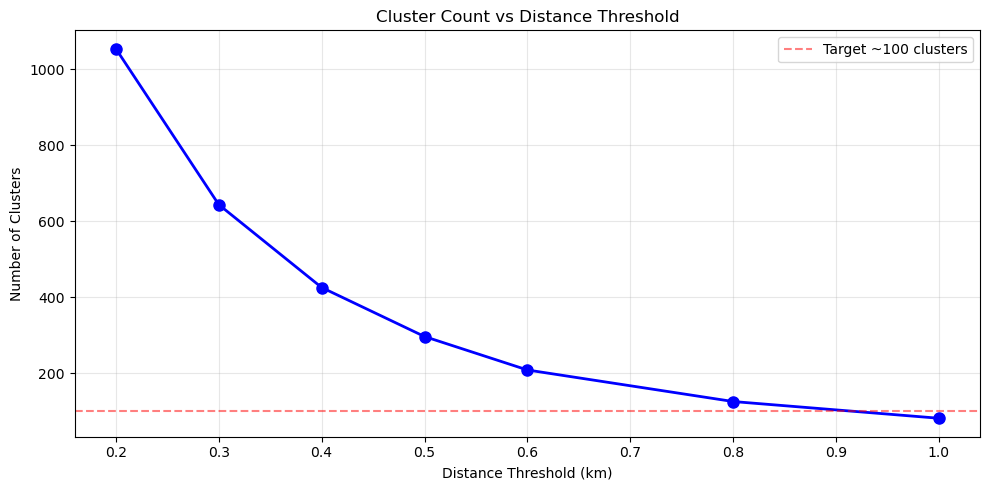

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([r['threshold'] for r in results], [r['n_clusters'] for r in results], 'bo-', linewidth=2, markersize=8)
ax.axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Target ~100 clusters')
ax.set_xlabel('Distance Threshold (km)')
ax.set_ylabel('Number of Clusters')
ax.set_title('Cluster Count vs Distance Threshold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

### Stage 1: Borough-Constrained Geographic Clustering

In [16]:
Distance_threshold_km = 0.9

station_features['geo_cluster'] = -1
current_cluster_id = 0

for borough in station_features['borough'].unique():
    borough_mask = station_features['borough'] == borough
    borough_indices = station_features[borough_mask].index.tolist()
    n_borough_stations = len(borough_indices)
    
    if n_borough_stations == 0:
        continue
    
    if n_borough_stations == 1:
        station_features.loc[borough_indices, 'geo_cluster'] = current_cluster_id
        print(f"{borough}: 1 station → 1 cluster")
        current_cluster_id += 1
        continue
    
    borough_matrix = haversine_matrix[np.ix_(borough_indices, borough_indices)]
    
    borough_clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=Distance_threshold_km,
        metric='precomputed',
        linkage='average'
    )
    borough_labels = borough_clustering.fit_predict(borough_matrix)
    
    station_features.loc[borough_indices, 'geo_cluster'] = borough_labels + current_cluster_id
    
    n_borough_clusters = len(np.unique(borough_labels))
    print(f"{borough}: {n_borough_stations} stations → {n_borough_clusters} clusters")
    current_cluster_id += n_borough_clusters

n_geo_clusters = station_features['geo_cluster'].nunique()
print(f"\nStage 1 Complete: {n_geo_clusters} geographic clusters")
print(f"Threshold: {Distance_threshold_km} km")

Brooklyn: 724 stations → 53 clusters
Manhattan: 713 stations → 48 clusters

Stage 1 Complete: 101 geographic clusters
Threshold: 0.9 km


### Stage 2: Demand Sub-Clustering

In [18]:
Demand_k = 2
demand_features = ['morning_leaving', 'morning_arriving', 'evening_leaving', 'evening_arriving']

demand_scaler = StandardScaler()
demand_scaled = demand_scaler.fit_transform(station_features[demand_features])

station_features['demand_subcluster'] = -1
skipped_clusters = 0

for geo_id in range(n_geo_clusters):
    mask = station_features['geo_cluster'] == geo_id
    n_stations_in_geo = mask.sum()

    if n_stations_in_geo < Demand_k:
        station_features.loc[mask, 'demand_subcluster'] = 0
        skipped_clusters += 1
    else:
        X_demand = demand_scaled[mask.values]
        kmeans = KMeans(n_clusters=Demand_k, random_state=42, n_init=10)
        subclusters = kmeans.fit_predict(X_demand)
        station_features.loc[mask, 'demand_subcluster'] = subclusters

station_features['cluster'] = (
    station_features['geo_cluster'] * Demand_k + 
    station_features['demand_subcluster']
).astype(int)

n_final_clusters = station_features['cluster'].nunique()
print(f"Skipped {skipped_clusters} geo clusters with < {Demand_k} stations")
print(f"Geographic clusters: {n_geo_clusters}")
print(f"Final clusters: {n_final_clusters}")
print(f"Avg stations per cluster: {len(station_features) / n_final_clusters:.1f}")

Skipped 3 geo clusters with < 2 stations
Geographic clusters: 101
Final clusters: 199
Avg stations per cluster: 7.2


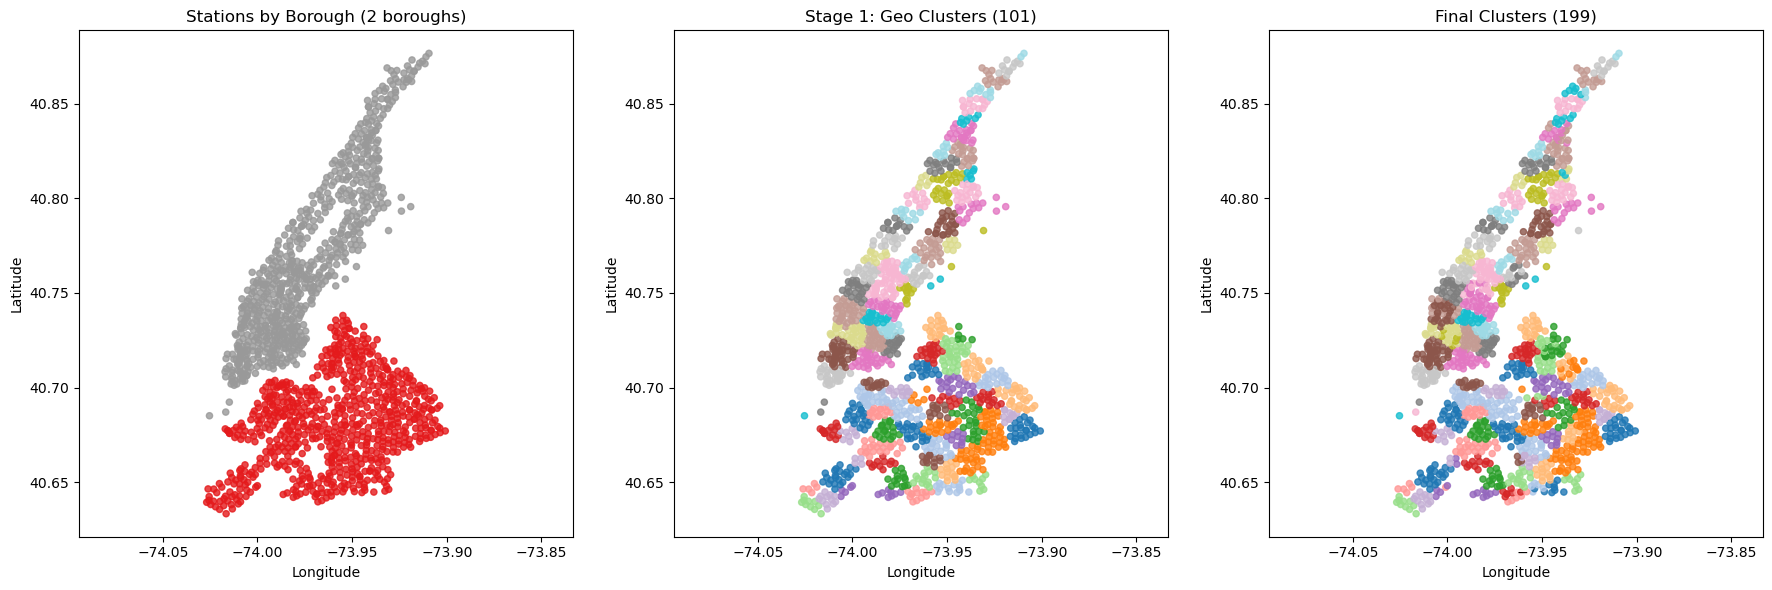

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Stations by Borough
borough_codes = station_features['borough'].astype('category').cat.codes
axes[0].scatter(station_features['lng'], station_features['lat'], c=borough_codes, cmap='Set1', s=20, alpha=0.8)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'Stations by Borough ({station_features["borough"].nunique()} boroughs)')
axes[0].axis('equal')

# Geographic Clusters (Stage 1)
axes[1].scatter(station_features['lng'], station_features['lat'], c=station_features['geo_cluster'], cmap='tab20', s=20, alpha=0.8)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title(f'Stage 1: Geo Clusters ({n_geo_clusters})')
axes[1].axis('equal')

# Final Clusters (Stage 1 + 2)
axes[2].scatter(station_features['lng'], station_features['lat'], c=station_features['cluster'], cmap='tab20', s=20, alpha=0.8)
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_title(f'Final Clusters ({n_final_clusters})')
axes[2].axis('equal')

plt.tight_layout()
plt.show()

### Save Cluster Assignments

In [21]:
station_clusters = station_features[['station_id', 'cluster', 'geo_cluster', 'borough', 'station_name', 'lat', 'lng']].copy()

station_clusters.to_csv('data/station_clusters.csv', index=False)

print(f"Saved to 'data/station_clusters.csv'")
print(f"Stations: {len(station_clusters)}")
print(f"Geographic clusters: {station_clusters['geo_cluster'].nunique()}")
print(f"Final clusters: {station_clusters['cluster'].nunique()}")
station_clusters.head()

Saved to 'data/station_clusters.csv'
Stations: 1437
Geographic clusters: 101
Final clusters: 199


,station_id,cluster,geo_cluster,borough,station_name,lat,lng
0,190 Morgan,30,15,Brooklyn,190 Morgan,40.711072,-73.932096
1,2733.03,52,26,Brooklyn,67 St & Erik Pl,40.633385,-74.016562
2,2782.02,52,26,Brooklyn,5 Ave & 67 St,40.635679,-74.020005
3,2821.06,99,49,Brooklyn,62 St & 7 Ave,40.635928,-74.013256
4,2832.03,52,26,Brooklyn,4 Ave & Shore Road Dr,40.637033,-74.022141


### Merge with Bike Changes Data

In [22]:
bike_changes = pd.read_csv('data/bike_changes_model.csv')

bike_changes['station_id'] = bike_changes['station_id'].astype(str).str.strip()
station_clusters['station_id'] = station_clusters['station_id'].astype(str).str.strip()

bike_ids = set(bike_changes['station_id'].unique())
cluster_ids = set(station_clusters['station_id'].unique())
overlap = bike_ids.intersection(cluster_ids)

print(f"Station ID matching:")
print(f"  In bike_changes: {len(bike_ids)}")
print(f"  In station_clusters: {len(cluster_ids)}")
print(f"  Matching: {len(overlap)}")

bike_changes_with_clusters = bike_changes.merge(
    station_clusters[['station_id', 'cluster', 'geo_cluster']], 
    on='station_id', 
    how='left'
)

missing = bike_changes_with_clusters['cluster'].isna().sum()
total = len(bike_changes_with_clusters)
print(f"\nMerge results: {total - missing:,} with clusters ({(total - missing)/total*100:.1f}%)")

if 0 < missing < total:
    bike_changes_with_clusters = bike_changes_with_clusters.dropna(subset=['cluster'])
    bike_changes_with_clusters['cluster'] = bike_changes_with_clusters['cluster'].astype(int)
    bike_changes_with_clusters['geo_cluster'] = bike_changes_with_clusters['geo_cluster'].astype(int)

/var/folders/gb/c9hsl88x245fsx9vr60m53600000gq/T/ipykernel_47178/3004192691.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  bike_changes = pd.read_csv('data/bike_changes_model.csv')


Station ID matching:
  In bike_changes: 1329
  In station_clusters: 1437
  Matching: 1327

Merge results: 224,556 with clusters (99.9%)


In [23]:
bike_changes_with_clusters.to_csv('data/bike_changes_with_clusters.csv', index=False)

print(f"Saved to 'data/bike_changes_with_clusters.csv'")
print(f"Shape: {bike_changes_with_clusters.shape}")
print(f"\nCluster features for modeling:")
print(f"  'cluster': {bike_changes_with_clusters['cluster'].nunique()} final clusters")
print(f"  'geo_cluster': {bike_changes_with_clusters['geo_cluster'].nunique()} geographic clusters")

Saved to 'data/bike_changes_with_clusters.csv'
Shape: (224556, 39)

Cluster features for modeling:
  'cluster': 197 final clusters
  'geo_cluster': 100 geographic clusters
